In [35]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler
import pandas as pd
import seaborn as sns
from sklearn import decomposition

In [127]:
##########################################################
# ------------------------------------------------------ #
# ----------------------- LOADING ---------------------- #
# ------------------------------------------------------ #
##########################################################
# Firstly the model loads the background and signal data, 
# then it removes the attributes first string line, which 
# are the column names, in order to avoid NaN values in 
# the array.

print('         ==== Commencing Initiation ====\n')

### Background
b_name='Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
Lb, W = background.shape
print("     .Background Loaded..." )
print("     .Background shape: {}".format(background.shape))

### Signal
s_name='Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
Ls, _ = signal.shape
print("     .Signal Loaded...")
print("     .Signal shape: {}\n".format(signal.shape))

### Selecting the most pertinent attributes

pertinent_features = [2,3,4,6,10,11,12,14,15,16,18,19,20]

background = background[:,pertinent_features]
signal = signal[:,pertinent_features]

         ==== Commencing Initiation ====

     .Background Loaded...
     .Background shape: (543500, 21)
     .Signal Loaded...
     .Signal shape: (522467, 21)



In [128]:
##########################################################
# ------------------------------------------------------ #
# --------------------- INITIATION --------------------- #
# ------------------------------------------------------ #
##########################################################

### Define Granularities to run
granularity = [1,2,3,4,5,6,7,8]

### Define User Variables ###
PROCESSES = 4

# Number of Iterations
iterations = 33

# Number of events
total = 20000

# Percentage of background samples on the testing phase
background_percent = 0.99

# Percentage of samples on the training phase
test_size = 0.3

In [129]:
# Percentage of background samples to divide the data-set
dat_set_percent = total/len(background)

In [130]:
print('\n          ==== Initiation Complete ====\n')
print('=*='*17 )
print('      ==== Commencing Data Processing ====')

# Reducing background samples
_,background = train_test_split(background, test_size=dat_set_percent)

# Dividing training and test sub-sets
training_data, streaming_background = train_test_split(background, test_size=test_size)

# Iserting the correct number of signal in streaming

n_signal_samples = int(len(streaming_background)*(1-background_percent))

_,streaming_background = train_test_split(streaming_background, test_size=background_percent)

_,signal = train_test_split(signal, test_size=n_signal_samples/len(signal))

# Concatenating Signal and the Background sub-sets

streaming_data = np.vstack((streaming_background,signal))
all_data = np.vstack((training_data,streaming_data))

print(".Training shape: {}".format(training_data.shape))
print(".Streaming shape: {}".format(streaming_data.shape))
print(".Streaming Background shape: {}".format(streaming_background.shape))
print(".Streaming Signal shape: {}".format(signal.shape))

# Normalize Data
print('.Normalizing Data')
streaming_data = normalize(streaming_data,norm='max',axis=0)
training_data = normalize(training_data,norm='max',axis=0)
all_data = normalize(all_data,norm='max',axis=0)


# Creating Labels
print('.Creating Labels')

y =np.ones((len(streaming_data)+len(training_data)))
y[:len(training_data) + len(streaming_background)] = 0
y[:len(training_data)] = -1
np.savetxt('results/target__.csv',y,delimiter=',')


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
      ==== Commencing Data Processing ====
.Training shape: (14000, 13)
.Streaming shape: (6000, 13)
.Streaming Background shape: (5940, 13)
.Streaming Signal shape: (60, 13)
.Normalizing Data
.Creating Labels


In [131]:
training_features = np.zeros(training_data.shape)
streaming_features = np.zeros(streaming_data.shape)
for i in range(len(training_data[0])):
    kde = stats.gaussian_kde(training_data[:,i])
    
    print('prob {}'.format(i))
    
    training_features[:,i] = kde(training_data[:,i])
    streaming_features[:,i] = kde(streaming_data[:,i])

    print('_'*8)


prob 0
________
prob 1
________
prob 2
________
prob 3
________
prob 4
________
prob 5
________
prob 6
________
prob 7
________
prob 8
________
prob 9
________
prob 10
________
prob 11
________
prob 12
________


In [134]:
results = pd.DataFrame(np.hstack((y[y!=-1].reshape(-1,1),streaming_features)),columns=['Type','pz1','E1','eta1','pt1','pz2','E2','eta2',
                                                            'pt2','Delta_R','M12','S','C','HT'])

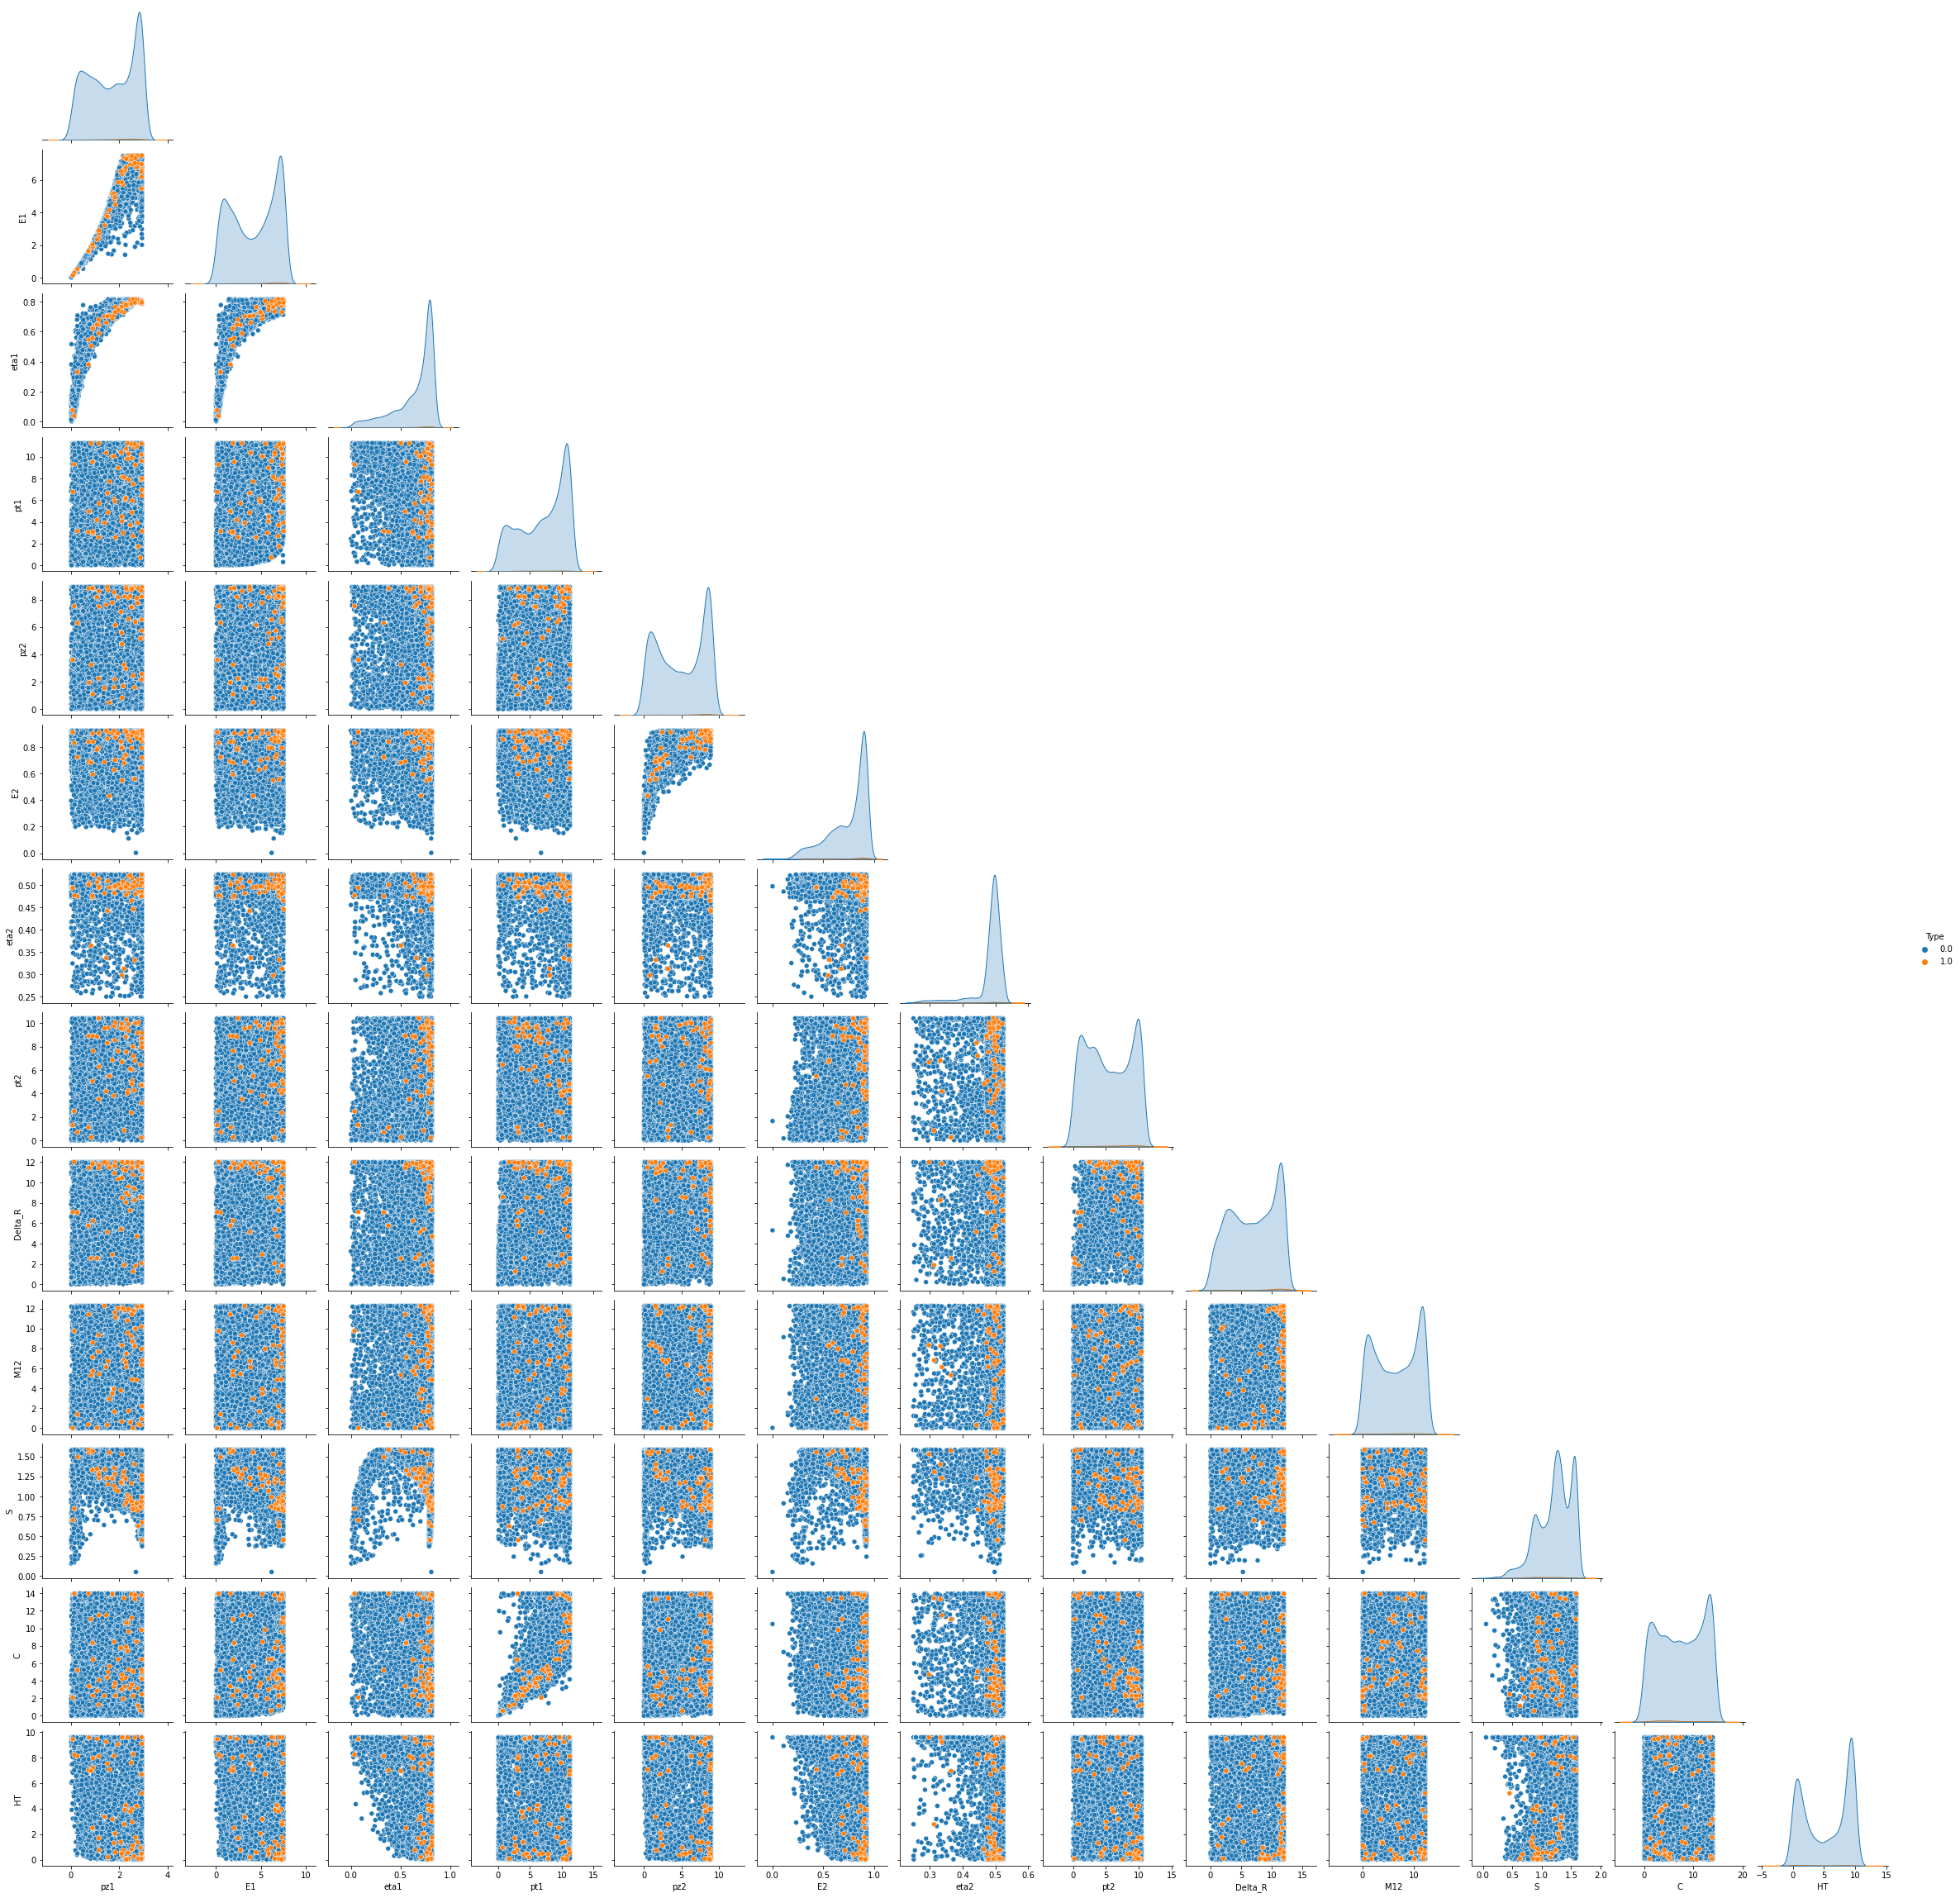

In [135]:
sns.pairplot(results,hue = 'Type',corner=True)

In [104]:
from sklearn.decomposition import FastICA, PCA

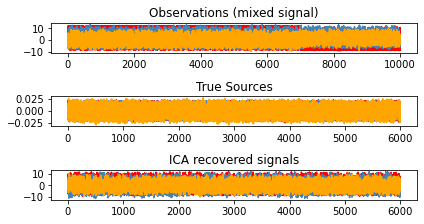

522.2751703056213


In [147]:
# Compute ICA
ica = FastICA(n_components=5)
S_ = ica.fit_transform(streaming_features)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# For comparison, compute PCA
pca = PCA(n_components=6)
H = pca.fit_transform(streaming_features)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure()

models = [X, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()
print(np.sum(A_))

In [148]:
type(S_)

numpy.ndarray

In [149]:
df = pd.DataFrame(np.hstack((y[y!=-1].reshape(-1,1),S_)), columns = ['Type','PC1','PC2','PC3','PC4','PC4'])
df.head()

,Type,PC1,PC2,PC3,PC4,PC4
0,0.0,-0.013426,-0.018775,0.010874,0.005649,-0.017909
1,0.0,-0.009809,0.014053,-0.013796,-0.005518,-0.010213
2,0.0,0.021638,-0.011652,0.007776,0.020278,0.015972
3,0.0,0.010150,0.003712,0.014706,-0.013109,-0.019536
4,0.0,-0.017135,-0.000003,0.001643,-0.002187,-0.012561


In [150]:
sns.pairplot(df,hue = 'Type',corner=True)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [83]:
def grid_set(data, N):
    _ , W = data.shape
    AvD1 = data.mean(0)
    X1 = np.mean(np.sum(np.power(data,2),axis=1))
    grid_trad = np.sqrt(2*(X1 - AvD1*AvD1.T))/N
    Xnorm = np.sqrt(np.sum(np.power(data,2),axis=1))
    aux = Xnorm
    for i in range(W-1):
        aux = np.insert(aux,0,Xnorm.T,axis=1)
    data = data / aux
    seq = np.argwhere(np.isnan(data))
    if tuple(seq[::]): data[tuple(seq[::])] = 1
    AvD2 = data.mean(0)
    grid_angl = np.sqrt(1-AvD2*AvD2.T)/N
    return X1, AvD1, AvD2, grid_trad, grid_angl

def pi_calculator(Uniquesample, mode):
    UN, W = Uniquesample.shape
    if mode == 'euclidean' or mode == 'mahalanobis' or mode == 'cityblock' or mode == 'chebyshev' or mode == 'canberra':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = []
        for i in range(UN): aux.append(AA1)
        aux2 = [Uniquesample[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.power(aux2,2),axis=1)+DT1

        
    if mode == 'minkowski':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = np.matrix(AA1)
        for i in range(UN-1): aux = np.insert(aux,0,AA1,axis=0)
        aux = np.array(aux)
        
        uspi = np.power(cdist(Uniquesample, aux, mode, p=1.5),2)+DT1
        uspi = uspi[:,0]

    if mode == 'cosine':
        Xnorm = np.matrix(np.sqrt(np.sum(np.power(Uniquesample,2),axis=1))).T
        aux2 = Xnorm
        for i in range(W-1):
            aux2 = np.insert(aux2,0,Xnorm.T,axis=1)
        Uniquesample1 = Uniquesample / aux2
        AA2 = np.mean(Uniquesample1,0)
        X2 = 1
        DT2 = X2 - np.sum(np.power(AA2,2))
        aux = []
        for i in range(UN): aux.append(AA2)
        aux2 = [Uniquesample1[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.sum(np.power(aux2,2),axis=1),axis=1)+DT2
        
    return uspi

def Globaldensity_Calculator(data, distancetype):
    Uniquesample = np.array(data)
    
    uspi1 = pi_calculator(Uniquesample, distancetype)

    sum_uspi1 = sum(uspi1)
    Density_1 = uspi1 / sum_uspi1

    uspi2 = pi_calculator(Uniquesample, 'cosine')

    sum_uspi2 = sum(uspi2)
    Density_2 = uspi2 / sum_uspi2

    return Density_1, Density_2 

In [151]:
D1, D2 = Globaldensity_Calculator(S_, 'euclidean')

In [152]:
df2 = pd.DataFrame(np.hstack((y[y!=].reshape(-1,1),np.hstack((D1.reshape(-1,1), D2.reshape(-1,1))))), 
                   columns = ['Type','D1','D2'])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 20000 and the array at index 1 has size 6000

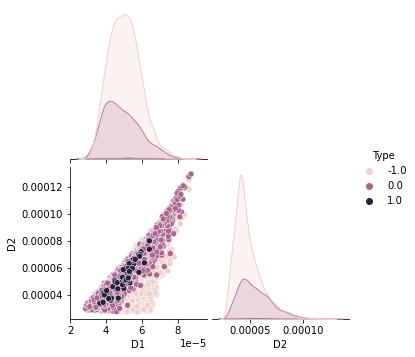

In [102]:
sns.pairplot(df2,hue = 'Type',corner=True)